<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-3-amg-basics/13-rotated-anisotropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# you may need to install pyamg
!pip install pyamg

In [1]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline

import pyamg

In [2]:
def trisolver(a, b, c, rhs):
    '''
    https://gist.github.com/TheoChristiaanse/d168b7e57dd30342a81aa1dc4eb3e469
    '''
    nf = len(rhs) # number of equations
    ac, bc, cc, rhsc = map(np.array, (a, b, c, rhs)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1] / bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        rhsc[it] = rhsc[it] - mc*rhsc[it-1]   
    xc = bc
    xc[-1] = rhsc[-1] / bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (rhsc[il] - cc[il] * xc[il+1]) / bc[il]

    return xc

In [3]:
def pointrelax(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    Dinv = sparse.spdiags(1./A.diagonal(), [0], n, n)
    omega = 4 / 5

    for i in range(nu):
        unew += omega * Dinv * (f - A * unew)
        
    return unew

def interpolation1d(nc, nf):
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    I = np.zeros((3,nc), dtype=int)
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    return 0.5 * P

def poissonop(n, sten):
    #sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    A = pyamg.gallery.stencil.stencil_grid(sten, (n, n))
    return A

In [4]:
def linerelax(A, u, f, nu,
              sten,
              direction='y'):
    """
    'y' -- constant x
    'x' -- constant y
    """
    n = int(np.sqrt(len(f))) # assume a square grid
    
    # get the stride
    # linesten -- the stencil for the 1d problem
    # offsten -- the weak stencil entries
    if direction == 'x':
        stride = 1
        linesten = sten[1,:]
        offsten = sten[[0,2],1]
    if direction == 'y':
        stride = n
        linesten = sten[:,1]
        offsten = sten[1,[0,2]]
    
    # build the three vectors for the tridiagonal solver
    T = np.array(linesten) * np.ones((n,3))
    
    f = f.reshape((n,n))
    unew = u.copy()
    unew = unew.reshape((n,n))
    
    # for each smoothing pass
    for _ in range(nu):
        # solve each line
        for i in range(n):
            if direction == 'x':
                fline = f[i,:].copy()
                if i > 1:
                    fline -= offsten[0] * unew[i-1,:]
                if i < (n-1):
                    fline -= offsten[1] * unew[i+1,:]

            if direction == 'y':
                fline = f[:,i].copy()
                if i > 1:
                    fline -= offsten[0] * unew[:,i-1]
                if i < (n-1):
                    fline -= offsten[1] * unew[:,i+1]

            uline = trisolver(T[:,0], T[:,1], T[:,2], fline)

            if direction == 'x':
                unew[i,:] = uline
            if direction == 'y':
                unew[:,i] = uline
    return unew.ravel()

In [16]:
def twogrid(A, P, A1, u0, f0, nu, sten=None):
    #u0 = pointrelax(A, u0, f0, nu)
    u0 = linerelax(A, u0, f0, nu, sten, direction='y')
    u0 = linerelax(A, u0, f0, nu, sten, direction='x')
    f1 = P.T * (f0 - A * u0)

    u1 = sla.spsolve(A1, f1)

    u0 = u0 + P * u1
    #u0 = pointrelax(A, u0, f0, nu)
    u0 = linerelax(A, u0, f0, nu, sten, direction='y')
    u0 = linerelax(A, u0, f0, nu, sten, direction='x')
    return u0

In [19]:
k = 7
n = 2**k - 1
nc = 2**(k-1) - 1
elist = np.logspace(-3,3,50)
thlist = np.linspace(0,np.pi/4,10)
m=20
allres = np.zeros((len(thlist),len(elist),m))

for i, theta in enumerate(thlist):
    print(f'{i} ', end='')
    for j, epsilon in enumerate(elist):
        u = np.random.rand(n*n)
        f = np.zeros((n,n)).ravel()
        sten = pyamg.gallery.diffusion_stencil_2d(epsilon,
                                                  theta=theta,
                                                  type='FD')
        A = (n+1)**2 * poissonop(n, sten)
        P1d = interpolation1d(nc, n)
        P = sparse.kron(P1d, P1d).tocsr()
        A1 = P.T * A * P
        for k in range(m):
            u = twogrid(A, P, A1, u, f, 1, (n+1)**2 * sten)
            res = np.linalg.norm(f - A * u)
            allres[i,j,k] = res

0 1 2 3 4 5 6 7 8 9 

Text(0, 0.5, 'convergence factor')

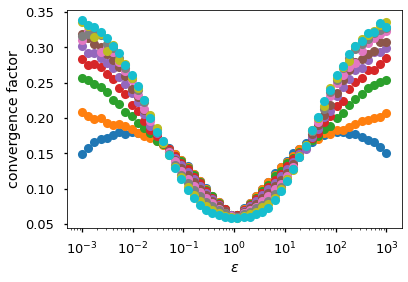

In [20]:
factors = np.zeros((len(thlist), len(elist)))
for i in range(len(thlist)):
    for j in range(len(elist)):
        factors[i,j] = (allres[i,j,-1] / allres[i,j,-5])**(1/5)

for i in range(len(thlist)):
    plt.semilogx(elist, factors[i,:], 'o', label=f'{thlist[i]}')
plt.xlabel('$\epsilon$')
plt.ylabel('convergence factor')
#plt.legend()